<a href="https://colab.research.google.com/github/amitabhswain/Predicting_Employee_AttritionRate/blob/master/Employee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
train=pd.read_csv('/content/drive/My Drive/Employees_leaving(hkereart)/Dataset/Train.csv')
test= pd.read_csv('/content/drive/My Drive/Employees_leaving(hkereart)/Dataset/Test.csv')
sample_submission= pd.read_csv('/content/drive/My Drive/Employees_leaving(hkereart)/Dataset/sample_submission.csv')


 mu = 0.19 and sigma = 0.19



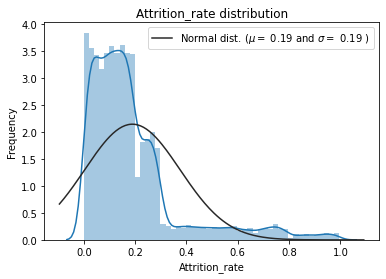

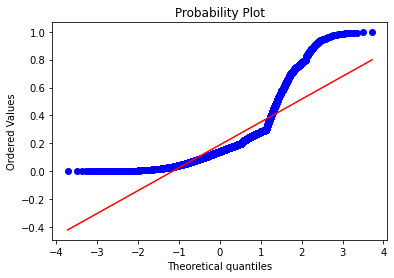

In [ ]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(train['Attrition_rate'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Attrition_rate'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Attrition_rate distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Attrition_rate'], plot=plt)
plt.show()


 mu = 0.16 and sigma = 0.14



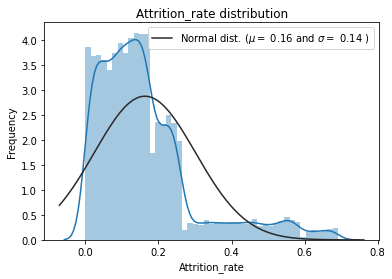

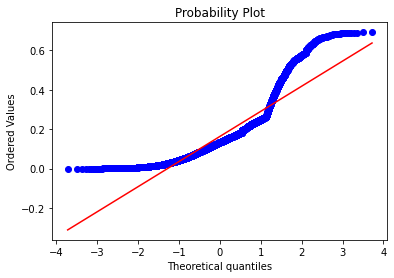

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train['Attrition_rate'] = np.log1p(train['Attrition_rate'])

#Check the new distribution 
sns.distplot(train['Attrition_rate'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Attrition_rate'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Attrition_rate distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Attrition_rate'], plot=plt)
plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.


In [ ]:
train.head(1)

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,33,1,1,7.0,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.168983


In [ ]:
train.to_csv("train_labels.csv",columns=train[['Attrition_rate']],index=False)
label=pd.read_csv('train_labels.csv')
label.head(6)
train=train.drop(columns=train[['Attrition_rate']],axis=1)



In [ ]:
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Employee_ID'], inplace=True, axis=1)
  

#Load train and test data into pandas DataFrames


#Combine train and test data to process them together


In [ ]:
combined.describe()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
count,9427.000000,10000.000000,9804.000000,10000.00000,10000.000000,10000.000000,10000.000000,9988.000000,9984.000000,10000.000000,9206.000000,10000.000000,9046.000000,10000.000000,10000.000000,10000.000000
mean,39.675507,3.199400,13.390657,2.37860,47.008400,0.820700,2.797000,6.022627,2.385817,3.089100,0.002653,-0.005826,1.895976,2.834800,7.110000,3.249600
std,13.574856,1.065436,10.311381,1.14978,15.848553,0.646524,1.171037,2.070087,1.128782,0.831884,0.992949,0.990812,0.533987,0.939466,1.160877,0.918795
min,19.000000,1.000000,0.000000,0.00000,20.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.817600,-2.776200,1.000000,1.000000,5.000000,1.000000
25%,27.000000,3.000000,5.000000,1.00000,33.000000,0.000000,2.000000,5.000000,1.000000,3.000000,-0.961200,-0.453700,2.000000,2.000000,6.000000,3.000000
50%,38.000000,3.000000,10.000000,2.00000,47.000000,1.000000,3.000000,6.000000,2.000000,3.000000,-0.104800,-0.453700,2.000000,3.000000,7.000000,3.000000
75%,52.000000,4.000000,21.000000,3.00000,61.000000,1.000000,4.000000,8.000000,3.000000,3.000000,0.751600,0.707500,2.000000,3.000000,8.000000,4.000000
max,65.000000,5.000000,43.000000,4.00000,74.000000,2.000000,5.000000,10.000000,5.000000,5.000000,1.608100,1.868800,3.000000,5.000000,9.000000,5.000000


In [ ]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [ ]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [ ]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 10
Number of nun-numerical columns with no nan values : 6


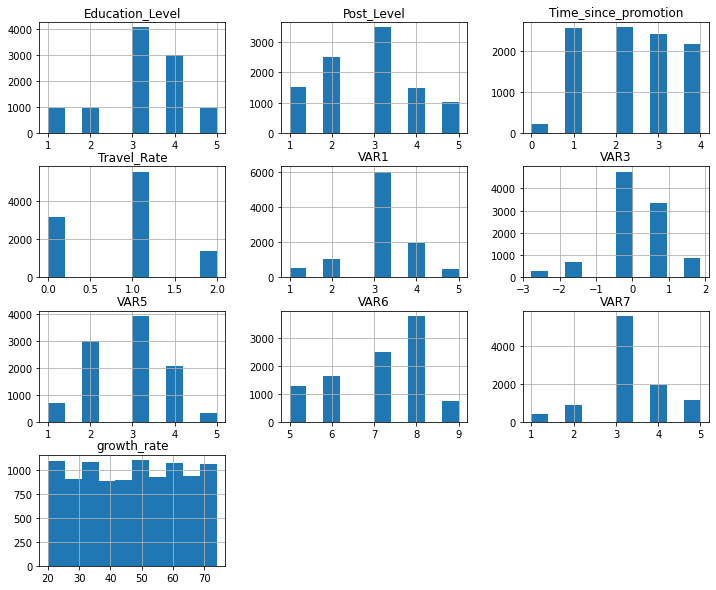

In [ ]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [ ]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 16 columns before encoding categorical features
There are 40 columns after encoding categorical features


In [ ]:
def split_combined():
    global combined
    train = combined[:7000]
    test = combined[7000:]

    return train , test 

In [ ]:
train, test = split_combined()

In [ ]:
train.shape

(7000, 40)

In [ ]:
test.shape

(3000, 40)

In [ ]:
NN_model = Sequential()
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [ ]:
NN_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adadelta(), metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 235,905
Trainable params: 235,905
Non-trainable params: 0
________________________________________________

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(train, label, epochs=200, batch_size=64, validation_split = 0.2, callbacks=callbacks_list)

Train on 5600 samples, validate on 1400 samples
Epoch 1/200
5600/5600 [==============================] - 1s 187us/step - loss: 0.1053 - mean_absolute_error: 0.1053 - val_loss: 0.1009 - val_mean_absolute_error: 0.1009

Epoch 00001: val_loss improved from inf to 0.10092, saving model to Weights-001--0.10092.hdf5
Epoch 2/200
5600/5600 [==============================] - 1s 117us/step - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.1114 - val_mean_absolute_error: 0.1114

Epoch 00002: val_loss did not improve from 0.10092
Epoch 3/200
5600/5600 [==============================] - 1s 118us/step - loss: 0.0959 - mean_absolute_error: 0.0959 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010

Epoch 00003: val_loss did not improve from 0.10092
Epoch 4/200
5600/5600 [==============================] - 1s 109us/step - loss: 0.0955 - mean_absolute_error: 0.0955 - val_loss: 0.1005 - val_mean_absolute_error: 0.1005

Epoch 00004: val_loss improved from 0.10092 to 0.10051, saving model to Weig

In [ ]:
# Load wights file of the best model :
wights_file = '/content/Weights-012--0.10000.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adadelta(),metrics=['mean_absolute_error'])

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Employee_ID':pd.read_csv('/content/drive/My Drive/Employees_leaving(hkereart)/Dataset/Test.csv').Employee_ID,'Attrition_rate':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [ ]:
predictions = NN_model.predict(test)

In [ ]:
test.head()

,Education_Level,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,VAR1,VAR3,VAR5,VAR6,VAR7,Gender_F,Gender_M,Relationship_Status_Married,Relationship_Status_Single,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,Unit_Operarions,Unit_Production,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4,Attrition_rate
7000,5,4,30,1,5,3,-0.4537,1,8,4,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0.133353
7001,2,2,72,1,1,4,0.7075,2,8,2,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.138024
7002,3,3,25,0,1,4,0.7075,1,9,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.131893
7003,5,4,28,1,1,3,0.7075,2,8,3,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.134322
7004,3,4,47,1,3,4,0.7075,2,7,4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0.130844


In [ ]:
make_submission(predictions[:,0],'Employee_v3(NN)')

A submission file has been made


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso= Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
lasso_regressor= GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(train,label)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1}
-0.019221316719562037


In [ ]:
from sklearn.metrics import mean_squared_error
lasso= Lasso(alpha=1)
lasso.fit(X=train,y=label)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
predictions = lasso.predict(test)
make_submission(predictions,'Employee_v1_lasso')

A submission file has been made


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train, label, test_size = 0.25, random_state = 14)


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(train, label)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 15.9min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:

best_grid.fit(train,label)
predicted_prices = best_grid.predict(test)
make_submission(predicted_prices,'Employee_v1_RF_grid')

A submission file has been made


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
model = RandomForestRegressor()
model.fit(train_X,train_y)
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.10274675644807703


In [ ]:
predicted_prices = model.predict(test)
make_submission(predicted_prices,'Employee_v1_RF')

A submission file has been made


In [ ]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

[14:58:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.09844607493513939


In [ ]:
XGBpredictions = XGBModel.predict(test)
make_submission(XGBpredictions,'Employee_v1_XGB')

A submission file has been made
